# 기본 준비

In [1]:
import pandas as pd
import numpy as np
import copy

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC

In [3]:
# 오차행렬 및 평가지표 출력
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('오차 행렬')
    print(confusion)

    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


# 임계값 조정하여 오차행렬 및 평가지표 출력
def get_eval_by_threshold(y_test, pred, pred_proba_c1, thresholds):
    pred_proba_c1 = pred_proba_c1.reshape(-1, 1)
    for custom_threshold in thresholds:
        bina = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = bina.transform(pred_proba_c1)
        print('분류 임계값 :', custom_threshold)
        get_clf_eval(y_test, custom_predict, pred_proba_c1)
    

# 임계값별로 precison_recall_curve 그리기
def precision_recall_curve_plot(y_test, pred_proba_c1): 
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]

    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision') 
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

In [39]:
def dict_to_params(model, params_dict):
    for key, value in params_dict.items():
        eval(f"model.set_params({key}=value)")
    return model


def grid_search_eval(model, params):
    model_list = []
    
    gs = GridSearchCV(estimator=model, param_grid=params, scoring=["accuracy", "f1", "recall", "precision"], 
                      refit=False, cv=3, verbose=2)
    gs.fit(X_train, y_train)
    
    result = pd.DataFrame(gs.cv_results_)
    
    best_results = result[(result["rank_test_accuracy"]<=3) | (result["rank_test_f1"]<=3) | 
                          (result["rank_test_recall"]<=3) | (result["rank_test_precision"]<=3)]
    
    for best_params in best_results["params"]:
        model_list.append(dict_to_params(copy.deepcopy(model), best_params))
    
    for best_model in model_list:
        best_model.fit(X_train, y_train)

        pred = best_model.predict(X_test)
        try:
            pred_proba = best_model.predict_proba(X_test)[:,1]
            print("="*100, "\n", best_model)
            print(best_model.score(X_train, y_train))
            print(best_model.score(X_test, y_test))
            get_clf_eval(y_test, pred, pred_proba)
        except:
            print("="*200)
            print("="*100, "\n", best_model)
            print(best_model.score(X_train, y_train))
            print(best_model.score(X_test, y_test))
            get_clf_eval(y_test, pred)
    
    return model_list, result



## 데이터 준비

In [5]:
def prepare_data():
    brfss = pd.read_csv("../data/brfss.csv")
    X = brfss.drop(["HEARTDISEASE", "ALCOHOL"], axis=1)
    y = brfss["HEARTDISEASE"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

    smote = SMOTE()
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print(y_train.value_counts())
    
    return X_train, X_test, y_train, y_test

In [ ]:
brfss = pd.read_csv("../data/brfss.csv")
X = brfss.drop(["HEARTDISEASE", "ALCOHOL"], axis=1)
y = brfss["HEARTDISEASE"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)
print(y_train.value_counts())

### with scaling

In [ ]:
brfss = pd.read_csv("../data/brfss.csv")
X = brfss.drop(["HEARTDISEASE", "ALCOHOL"], axis=1)
y = brfss["HEARTDISEASE"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

scaler = StandardScaler()
# scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)
y_train.value_counts()

# 할 일
- 하이퍼 파라미터 튜닝
    - 각 모델 document 보면서 찾아보기
- 임계점 변경
    - 변경해보면서 최적값 찾기

# 박민정

## Data
- 건강검진 데이터의 KIDNEY 조건 변경 검토
```
data["KIDNEY"] = data.apply(lambda x: 1 if x["요단백"]>=3 or x["혈청크레아티닌"]>1.7 or x["혈청크레아티닌"]<0.8 else 0, axis=1)
0    1295062
1     744182
```
```
data["KIDNEY"] = data.apply(lambda x: 1 if x["요단백"]>=3 and (x["혈청크레아티닌"]>1.7 or x["혈청크레아티닌"]<0.8) else 0, axis=1)
0    2020722
1      18522
```

## DecisionTree

### base model

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

In [ ]:
# 임계값 그래프
precision_recall_curve_plot(y_test, pred_proba)

In [ ]:
# 임계값 조정
thresholds = [.5, .55, .6, .65, .7, .75, .8, .85]
get_eval_by_threshold(y_test, pred, pred_proba, thresholds)

### 모델링
- 하이퍼 파라미터    
    - criterion: ```"gini", "entropy", "log_loss"```
    - splitter: ```"best", "random"```
    - max_depth: ```~~~~~~~~~~~~~```   
    - max_features: ```"sqrt", "log2", None```
    - min_impurity_decrease: ```~~~~~~~~~~~~~~```
    - class_weight: ```"balanced", None```
    - ccp_alpha: ```~~~~~~~~~~~~~~~~~~```
- 사용하지 않은 하이퍼 파라미터
    - min_samples_split: int or float, default=2
    - min_samples_leaf: int or float, default=1

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

#### 트리 관련

In [ ]:
params = {
    "max_depth": range(1, 10, 1),
    "min_samples_split": range(2, 102, 10),
    "min_samples_leaf": range(1, 10, 1),
    "max_leaf_nodes": range(1, 11, 1),
    "min_impurity_decrease": np.arange(0.0001, 0.001, 0.0001),
    "ccp_alpha": np.arange(0.0, 0.04, 0.005),
}

X_train, X_test, y_train, y_test = prepare_data()
model = DecisionTreeClassifier()
model_list, result = grid_search_eval(model, params)

#### 전체 

In [ ]:
all_params = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"], 
    "max_depth": range(1, 10, 1),
    "min_samples_split": range(2, 102, 10),
    "min_samples_leaf": range(1, 21, 1),
    "max_features": ["sqrt", "log2", None],
    "max_leaf_nodes": range(1, 11, 1),
    "min_impurity_decrease": np.arange(0.0001, 0.001, 0.0001),
    "class_weight": ["balanced", None],
    "ccp_alpha": np.arange(0.0, 0.04, 0.005),
}

X_train, X_test, y_train, y_test = prepare_data()
model = DecisionTreeClassifier()
model_list, result = grid_search_eval(model, all_params)

### 임계값 변경
- 의료 데이터이므로 높이는 쪽으로

## SGDClassifier
- 하이퍼 파라미터
    - loss: ```"hinge", "log_loss", "modified_huber", "squared_hinge", "perceptron"```
        - "squared_error", "huber", "epsilon_insensitive", "squared_epsilon_insensitive": regression에서 사용하는 함수라서 제외
    - penalty: ```"l2", "l1", "elasticnet", None```
    - alpha: ```0.0001, 0.001, 0.01, 0.1```
    - learning_rate: ```"constant", "optimal", "invscaling"```
    - class_weight: ```"balanced", None```

- 고정된 하이퍼 파라미터
    - early_stopping: ```True```
    - n_iter_no_change: ```5```
- 사용하지 않은 하이퍼 파라미터
    - fit_intercept
    - max_iter
    - tol
    - shuffle
    - epsilon    
    
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

In [ ]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(loss="log_loss", max_iter=10)
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

In [23]:
params = {
    "loss": ["hinge", "log_loss", "modified_huber"], # "squared_hinge", "perceptron"], 
             # "squared_error", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"],
    "penalty": ["l2", "l1", "elasticnet", None], 
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "learning_rate": ["constant", "optimal", "invscaling"],
    "class_weight": ["balanced", None],
}

X_train, X_test, y_train, y_test = prepare_data()
model = SGDClassifier(early_stopping=True, n_iter_no_change=5)
result = grid_search_eval(model, params)

1.0    286732
0.0    286732
Name: HEARTDISEASE, dtype: int64
Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=constant, loss=hinge, penalty=l2; total time=   0.0s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=constant, loss=hinge, penalty=l2; total time=   0.0s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=constant, loss=hinge, penalty=l2; total time=   0.0s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=constant, loss=hinge, penalty=l1; total time=   0.0s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=constant, loss=hinge, penalty=l1; total time=   0.0s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=constant, loss=hinge, penalty=l1; total time=   0.0s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=constant, loss=hinge, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=constant, loss=hi

[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=modified_huber, penalty=elasticnet; total time=   0.8s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=modified_huber, penalty=None; total time=   1.1s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=modified_huber, penalty=None; total time=   0.9s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=modified_huber, penalty=None; total time=   0.7s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=invscaling, loss=hinge, penalty=l2; total time=   0.0s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=invscaling, loss=hinge, penalty=l2; total time=   0.0s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=invscaling, loss=hinge, penalty=l2; total time=   0.0s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=invscaling, loss=hinge, penalty=l1; total time=   0.0s
[CV] END alpha=0.0001, class_weight=balanc

[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=hinge, penalty=l2; total time=   0.9s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=hinge, penalty=l2; total time=   0.6s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=hinge, penalty=l2; total time=   0.6s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=hinge, penalty=l1; total time=   0.7s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=hinge, penalty=l1; total time=   0.7s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=hinge, penalty=l1; total time=   0.8s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=hinge, penalty=elasticnet; total time=   0.7s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=hinge, penalty=elasticnet; total time=   0.7s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=hinge, penalty=elasticnet; total time=   1.0s
[CV]

[CV] END alpha=0.001, class_weight=balanced, learning_rate=constant, loss=hinge, penalty=l2; total time=   0.0s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=constant, loss=hinge, penalty=l2; total time=   0.0s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=constant, loss=hinge, penalty=l2; total time=   0.0s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=constant, loss=hinge, penalty=l1; total time=   0.0s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=constant, loss=hinge, penalty=l1; total time=   0.0s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=constant, loss=hinge, penalty=l1; total time=   0.0s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=constant, loss=hinge, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=constant, loss=hinge, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=constant, loss=hinge, penalty

[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=modified_huber, penalty=None; total time=   0.8s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=modified_huber, penalty=None; total time=   0.9s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=invscaling, loss=hinge, penalty=l2; total time=   0.0s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=invscaling, loss=hinge, penalty=l2; total time=   0.0s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=invscaling, loss=hinge, penalty=l2; total time=   0.0s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=invscaling, loss=hinge, penalty=l1; total time=   0.0s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=invscaling, loss=hinge, penalty=l1; total time=   0.0s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=invscaling, loss=hinge, penalty=l1; total time=   0.0s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=invscaling, l

[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=hinge, penalty=l2; total time=   0.8s
[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=hinge, penalty=l2; total time=   0.7s
[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=hinge, penalty=l2; total time=   0.8s
[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=hinge, penalty=l1; total time=   0.8s
[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=hinge, penalty=l1; total time=   0.9s
[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=hinge, penalty=l1; total time=   1.1s
[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=hinge, penalty=elasticnet; total time=   0.9s
[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=hinge, penalty=elasticnet; total time=   0.9s
[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=hinge, penalty=elasticnet; total time=   1.0s
[CV] END alph

[CV] END alpha=0.01, class_weight=balanced, learning_rate=constant, loss=hinge, penalty=l1; total time=   0.0s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=constant, loss=hinge, penalty=l1; total time=   0.0s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=constant, loss=hinge, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=constant, loss=hinge, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=constant, loss=hinge, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=constant, loss=hinge, penalty=None; total time=   0.0s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=constant, loss=hinge, penalty=None; total time=   0.0s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=constant, loss=hinge, penalty=None; total time=   0.0s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=constant, loss=log_loss,

[CV] END alpha=0.01, class_weight=balanced, learning_rate=invscaling, loss=hinge, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=invscaling, loss=hinge, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=invscaling, loss=hinge, penalty=None; total time=   0.0s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=invscaling, loss=hinge, penalty=None; total time=   0.0s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=invscaling, loss=hinge, penalty=None; total time=   0.0s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=invscaling, loss=log_loss, penalty=l2; total time=   0.0s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=invscaling, loss=log_loss, penalty=l2; total time=   0.0s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=invscaling, loss=log_loss, penalty=l2; total time=   0.0s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=invscal

[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=hinge, penalty=elasticnet; total time=   0.7s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=hinge, penalty=elasticnet; total time=   0.9s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=hinge, penalty=elasticnet; total time=   0.7s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=hinge, penalty=None; total time=   0.7s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=hinge, penalty=None; total time=   0.7s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=hinge, penalty=None; total time=   0.6s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=log_loss, penalty=l2; total time=   0.7s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=log_loss, penalty=l2; total time=   0.7s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=log_loss, penalty=l2; total time=   0.7s
[CV] EN

[CV] END alpha=0.1, class_weight=balanced, learning_rate=constant, loss=hinge, penalty=None; total time=   0.0s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=constant, loss=hinge, penalty=None; total time=   0.0s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=constant, loss=log_loss, penalty=l2; total time=   0.0s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=constant, loss=log_loss, penalty=l2; total time=   0.0s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=constant, loss=log_loss, penalty=l2; total time=   0.0s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=constant, loss=log_loss, penalty=l1; total time=   0.0s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=constant, loss=log_loss, penalty=l1; total time=   0.0s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=constant, loss=log_loss, penalty=l1; total time=   0.0s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=constant, loss=log_loss, penalty=elasticn

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log_loss, penalty=l1; total time=   1.3s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log_loss, penalty=elasticnet; total time=   1.2s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log_loss, penalty=elasticnet; total time=   0.9s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log_loss, penalty=elasticnet; total time=   1.0s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log_loss, penalty=None; total time=   1.0s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log_loss, penalty=None; total time=   0.9s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log_loss, penalty=None; total time=   0.9s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=modified_huber, penalty=l2; total time=   0.8s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, lo

[CV] END alpha=0.1, class_weight=None, learning_rate=constant, loss=log_loss, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.1, class_weight=None, learning_rate=constant, loss=log_loss, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.1, class_weight=None, learning_rate=constant, loss=log_loss, penalty=None; total time=   0.0s
[CV] END alpha=0.1, class_weight=None, learning_rate=constant, loss=log_loss, penalty=None; total time=   0.0s
[CV] END alpha=0.1, class_weight=None, learning_rate=constant, loss=log_loss, penalty=None; total time=   0.0s
[CV] END alpha=0.1, class_weight=None, learning_rate=constant, loss=modified_huber, penalty=l2; total time=   0.0s
[CV] END alpha=0.1, class_weight=None, learning_rate=constant, loss=modified_huber, penalty=l2; total time=   0.0s
[CV] END alpha=0.1, class_weight=None, learning_rate=constant, loss=modified_huber, penalty=l2; total time=   0.0s
[CV] END alpha=0.1, class_weight=None, learning_rate=constant, loss=modified_huber, pena

[CV] END alpha=0.1, class_weight=None, learning_rate=invscaling, loss=log_loss, penalty=None; total time=   0.0s
[CV] END alpha=0.1, class_weight=None, learning_rate=invscaling, loss=log_loss, penalty=None; total time=   0.0s
[CV] END alpha=0.1, class_weight=None, learning_rate=invscaling, loss=log_loss, penalty=None; total time=   0.0s
[CV] END alpha=0.1, class_weight=None, learning_rate=invscaling, loss=modified_huber, penalty=l2; total time=   0.0s
[CV] END alpha=0.1, class_weight=None, learning_rate=invscaling, loss=modified_huber, penalty=l2; total time=   0.0s
[CV] END alpha=0.1, class_weight=None, learning_rate=invscaling, loss=modified_huber, penalty=l2; total time=   0.0s
[CV] END alpha=0.1, class_weight=None, learning_rate=invscaling, loss=modified_huber, penalty=l1; total time=   0.0s
[CV] END alpha=0.1, class_weight=None, learning_rate=invscaling, loss=modified_huber, penalty=l1; total time=   0.0s
[CV] END alpha=0.1, class_weight=None, learning_rate=invscaling, loss=modifi

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
576 fits failed out of a total of 864.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
576 fits failed with the following error:
Traceback (most recent call last):
  File "D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 890, in fit
    return self._fit(
  File "D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 658, in _fit
    self._vali

In [24]:
grid_search_eval_precision(model, result)

 SGDClassifier(class_weight='balanced', early_stopping=True,
              loss='modified_huber', penalty='l1')
0.6993028333077578
0.6890664201769444
오차 행렬
[[49254 22438]
 [ 1109  2929]]
정확도: 0.6891, 정밀도: 0.1155, 재현율: 0.7254, F1: 0.1992, AUC:0.7732
 SGDClassifier(class_weight='balanced', early_stopping=True,
              loss='modified_huber', penalty=None)
0.7031531185915768
0.6810246929882477
오차 행렬
[[48578 23114]
 [ 1042  2996]]
정확도: 0.6810, 정밀도: 0.1147, 재현율: 0.7420, F1: 0.1988, AUC:0.7754
 SGDClassifier(early_stopping=True, loss='modified_huber')
0.7047783295900004
0.6759276376601083
오차 행렬
[[48148 23544]
 [  998  3040]]
정확도: 0.6759, 정밀도: 0.1144, 재현율: 0.7528, F1: 0.1986, AUC:0.7706
 SGDClassifier(early_stopping=True, loss='modified_huber', penalty='elasticnet')
0.7048149491511237
0.6759276376601083
오차 행렬
[[48148 23544]
 [  998  3040]]
정확도: 0.6759, 정밀도: 0.1144, 재현율: 0.7528, F1: 0.1986, AUC:0.7745
 SGDClassifier(alpha=0.001, early_stopping=True, loss='log_loss', penalty='l1')
0.704807

In [30]:
# result.fillna(0, inplace=True)
for col in result.columns:
    if col.startswith("param_"):
        print(result.groupby(col).mean()[["mean_test_precision"]])

             mean_test_precision
param_alpha                     
0.0001                  0.228381
0.0010                  0.227389
0.0100                  0.227110
0.1000                  0.219048
                    mean_test_precision
param_class_weight                     
0                              0.225969
balanced                       0.224995
                     mean_test_precision
param_learning_rate                     
constant                        0.000000
invscaling                      0.000000
optimal                         0.676447
                mean_test_precision
param_loss                         
hinge                      0.220713
log_loss                   0.225153
modified_huber             0.230581
               mean_test_precision
param_penalty                     
0                         0.227678
elasticnet                0.227545
l1                        0.219262
l2                        0.227444


C:\Users\ParkMinjeong\AppData\Local\Temp\ipykernel_19700\1993093451.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(result.groupby(col).mean()[["mean_test_precision"]])
C:\Users\ParkMinjeong\AppData\Local\Temp\ipykernel_19700\1993093451.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(result.groupby(col).mean()[["mean_test_precision"]])
C:\Users\ParkMinjeong\AppData\Local\Temp\ipykernel_19700\1993093451.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or selec

In [33]:
params = {
    "loss": ["hinge", "log_loss", "modified_huber", "log", "squared_hinge", "perceptron"], 
    "penalty": ["l2", "l1", "elasticnet", None], 
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "learning_rate": ["optimal"],
    "class_weight": ["balanced", None],
}

X_train, X_test, y_train, y_test = prepare_data()
model = SGDClassifier(early_stopping=True, n_iter_no_change=5)
model_list, result = grid_search_eval(model, params)

0.0    286742
1.0    286742
Name: HEARTDISEASE, dtype: int64
Fitting 3 folds for each of 192 candidates, totalling 576 fits
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=hinge, penalty=l2; total time=   0.8s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=hinge, penalty=l2; total time=   0.6s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=hinge, penalty=l2; total time=   0.6s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=hinge, penalty=l1; total time=   0.7s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=hinge, penalty=l1; total time=   0.8s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=hinge, penalty=l1; total time=   0.7s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=hinge, penalty=elasticnet; total time=   0.9s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=hinge, pen

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=log, penalty=l2; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=log, penalty=l2; total time=   0.7s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=log, penalty=l2; total time=   0.7s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=log, penalty=l1; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=log, penalty=l1; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=log, penalty=l1; total time=   0.9s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=log, penalty=elasticnet; total time=   0.7s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=log, penalty=elasticnet; total time=   0.7s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=log, penalty=elasticnet; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=log, penalty=None; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=log, penalty=None; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=log, penalty=None; total time=   0.8s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=l2; total time=   0.9s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=l2; total time=   0.7s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=l2; total time=   0.7s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=l1; total time=   1.0s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=l1; total time=   0.8s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=l1; total time=   1.0s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=elasticnet; total time=   0.7s
[CV] END alpha=0.0001, class_weight=bala

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=log, penalty=l2; total time=   1.0s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=log, penalty=l2; total time=   1.1s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=log, penalty=l2; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=log, penalty=l1; total time=   1.2s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=log, penalty=l1; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=log, penalty=l1; total time=   0.9s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=log, penalty=elasticnet; total time=   1.0s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=log, penalty=elasticnet; total time=   0.9s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=log, penalty=elasticnet; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=log, penalty=None; total time=   0.9s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=log, penalty=None; total time=   1.1s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=log, penalty=None; total time=   1.1s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=l2; total time=   0.8s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=l2; total time=   0.8s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=l2; total time=   0.7s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=l1; total time=   1.1s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=l1; total time=   1.1s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=l1; total time=   1.1s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=elasticnet; total time=   0.9s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=sq

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=perceptron, penalty=l1; total time=   0.7s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=perceptron, penalty=l1; total time=   0.7s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=perceptron, penalty=elasticnet; total time=   1.2s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=perceptron, penalty=elasticnet; total time=   0.7s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=perceptron, penalty=elasticnet; total time=   0.8s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=perceptron, penalty=None; total time=   1.0s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=perceptron, penalty=None; total time=   0.7s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=perceptron, penalty=None; total time=   0.9s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=log, penalty=l2; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=log, penalty=l2; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=log, penalty=l2; total time=   0.7s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=log, penalty=l1; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=log, penalty=l1; total time=   0.9s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=log, penalty=l1; total time=   0.9s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=log, penalty=elasticnet; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=log, penalty=elasticnet; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=log, penalty=elasticnet; total time=   0.9s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=log, penalty=None; total time=   1.0s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=log, penalty=None; total time=   1.1s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=log, penalty=None; total time=   1.0s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=l2; total time=   0.7s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=l2; total time=   0.7s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=l2; total time=   0.7s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=l1; total time=   0.9s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=l1; total time=   0.9s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=l1; total time=   1.1s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=elasticnet; total time=   0.9s
[CV] END alpha=0.001, class_weight=balanced, lea

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=perceptron, penalty=l1; total time=   1.3s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=perceptron, penalty=elasticnet; total time=   1.2s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=perceptron, penalty=elasticnet; total time=   1.0s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=perceptron, penalty=elasticnet; total time=   0.9s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=perceptron, penalty=None; total time=   1.0s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=perceptron, penalty=None; total time=   0.9s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=perceptron, penalty=None; total time=   1.0s
[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=hinge, penalty=l2; total time=   0.7s
[CV] END alpha=0.001, class_weight=None, learning_r

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=log, penalty=l2; total time=   0.7s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=log, penalty=l2; total time=   0.7s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=log, penalty=l2; total time=   0.7s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=log, penalty=l1; total time=   0.7s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=log, penalty=l1; total time=   0.9s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=log, penalty=l1; total time=   0.7s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=log, penalty=elasticnet; total time=   0.7s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=log, penalty=elasticnet; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=log, penalty=elasticnet; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=log, penalty=None; total time=   0.7s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=log, penalty=None; total time=   0.7s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=log, penalty=None; total time=   0.7s
[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=l2; total time=   0.6s
[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=l2; total time=   0.7s
[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=l2; total time=   0.7s
[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=l1; total time=   0.7s
[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=l1; total time=   1.0s
[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=l1; total time=   0.7s
[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=elasticnet; total time=   0.9s
[CV] END alpha=0.001, class_weight=None, learning_rate=optimal, loss=squared_hin

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=log, penalty=l2; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=log, penalty=l2; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=log, penalty=l2; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=log, penalty=l1; total time=   0.9s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=log, penalty=l1; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=log, penalty=l1; total time=   0.9s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=log, penalty=elasticnet; total time=   1.0s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=log, penalty=elasticnet; total time=   1.0s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=log, penalty=elasticnet; total time=   0.9s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=log, penalty=None; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=log, penalty=None; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=log, penalty=None; total time=   0.8s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=l2; total time=   0.7s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=l2; total time=   0.8s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=l2; total time=   0.7s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=l1; total time=   1.0s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=l1; total time=   0.9s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=l1; total time=   1.1s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=elasticnet; total time=   0.8s
[CV] END alpha=0.01, class_weight=balanced, learning_rat

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=perceptron, penalty=l1; total time=   0.9s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=perceptron, penalty=elasticnet; total time=   0.8s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=perceptron, penalty=elasticnet; total time=   0.8s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=perceptron, penalty=elasticnet; total time=   1.1s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=perceptron, penalty=None; total time=   0.8s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=perceptron, penalty=None; total time=   0.9s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=perceptron, penalty=None; total time=   0.7s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=hinge, penalty=l2; total time=   0.6s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=hinge, penalty=l2; total time=   0.6s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=log, penalty=l2; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=log, penalty=l2; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=log, penalty=l2; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=log, penalty=l1; total time=   1.0s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=log, penalty=l1; total time=   1.0s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=log, penalty=l1; total time=   1.2s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=log, penalty=elasticnet; total time=   0.9s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=log, penalty=elasticnet; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=log, penalty=elasticnet; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=log, penalty=None; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=log, penalty=None; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=log, penalty=None; total time=   0.7s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=l2; total time=   0.7s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=l2; total time=   0.8s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=l2; total time=   0.7s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=l1; total time=   0.9s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=l1; total time=   0.8s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=l1; total time=   1.2s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=elasticnet; total time=   0.8s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=squared_hinge, penal

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log_loss, penalty=l1; total time=   0.9s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log_loss, penalty=l1; total time=   0.8s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log_loss, penalty=l1; total time=   0.8s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log_loss, penalty=elasticnet; total time=   0.8s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log_loss, penalty=elasticnet; total time=   1.0s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log_loss, penalty=elasticnet; total time=   1.2s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log_loss, penalty=None; total time=   1.0s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log_loss, penalty=None; total time=   1.2s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log_loss, penalty=None; total time=   0.8s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=mod

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log, penalty=l2; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log, penalty=l2; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log, penalty=l2; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log, penalty=l1; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log, penalty=l1; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log, penalty=l1; total time=   0.9s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log, penalty=elasticnet; total time=   1.0s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log, penalty=elasticnet; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log, penalty=elasticnet; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log, penalty=None; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log, penalty=None; total time=   0.9s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=log, penalty=None; total time=   0.7s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=l2; total time=   0.8s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=l2; total time=   0.7s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=l2; total time=   0.7s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=l1; total time=   0.7s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=l1; total time=   1.3s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=l1; total time=   0.7s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=squared_hinge, penalty=elasticnet; total time=   0.7s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=perceptron, penalty=l1; total time=   0.6s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=perceptron, penalty=l1; total time=   0.7s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=perceptron, penalty=l1; total time=   0.7s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=perceptron, penalty=elasticnet; total time=   0.9s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=perceptron, penalty=elasticnet; total time=   0.8s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=perceptron, penalty=elasticnet; total time=   0.7s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=perceptron, penalty=None; total time=   0.7s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=perceptron, penalty=None; total time=   1.7s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=perceptron, penalty=None; total time=   0.8s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=hinge, penalty=l2; total time=   0.7s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=log_loss, penalty=l1; total time=   0.9s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=log_loss, penalty=l1; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=log_loss, penalty=l1; total time=   0.8s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=log_loss, penalty=elasticnet; total time=   0.8s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=log_loss, penalty=elasticnet; total time=   0.9s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=log_loss, penalty=elasticnet; total time=   0.8s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=log_loss, penalty=None; total time=   0.7s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=log_loss, penalty=None; total time=   0.8s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=log_loss, penalty=None; total time=   0.8s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=modified_huber, penalty=l2; total time=   0.7s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=modified_huber, penalty=l2; total

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=log, penalty=l2; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=log, penalty=l2; total time=   0.9s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=log, penalty=l2; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=log, penalty=l1; total time=   0.9s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=log, penalty=l1; total time=   0.8s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=log, penalty=l1; total time=   0.9s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=log, penalty=elasticnet; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=log, penalty=elasticnet; total time=   0.9s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=log, penalty=elasticnet; total time=   0.9s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=log, penalty=None; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=log, penalty=None; total time=   0.7s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=log, penalty=None; total time=   0.7s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=l2; total time=   0.8s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=l2; total time=   0.7s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=l2; total time=   0.8s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=l1; total time=   0.8s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=l1; total time=   1.4s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=l1; total time=   0.8s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=elasticnet; total time=   0.9s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=squared_hinge, penalty=elasti

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=perceptron, penalty=l1; total time=   0.8s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=perceptron, penalty=l1; total time=   0.8s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=perceptron, penalty=elasticnet; total time=   1.0s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=perceptron, penalty=elasticnet; total time=   1.2s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=perceptron, penalty=elasticnet; total time=   0.8s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=perceptron, penalty=None; total time=   0.7s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=perceptron, penalty=None; total time=   0.8s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=perceptron, penalty=None; total time=   1.1s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


 SGDClassifier(class_weight='balanced', early_stopping=True, loss='log',
              penalty=None)
0.7082324877415935
0.6692988247722171
오차 행렬
[[47694 23988]
 [ 1056  2992]]
정확도: 0.6693, 정밀도: 0.1109, 재현율: 0.7391, F1: 0.1929, AUC:0.7650
 SGDClassifier(early_stopping=True, loss='log_loss', penalty='elasticnet')
0.7080110343095884
0.6697213785818038
오차 행렬
[[47732 23950]
 [ 1062  2986]]
정확도: 0.6697, 정밀도: 0.1109, 재현율: 0.7376, F1: 0.1927, AUC:0.7653
 SGDClassifier(early_stopping=True, loss='modified_huber')
0.7071967134218217
0.6728509177340551
오차 행렬
[[48003 23679]
 [ 1096  2952]]
정확도: 0.6729, 정밀도: 0.1108, 재현율: 0.7292, F1: 0.1924, AUC:0.7636
SGDClassifier(early_stopping=True, loss='perceptron', penalty='elasticnet')
 SGDClassifier(early_stopping=True, loss='perceptron', penalty='elasticnet')
0.6944169322945366
0.5922619833619438
오차 행렬
[[41678 30004]
 [  874  3174]]
정확도: 0.5923, 정밀도: 0.0957, 재현율: 0.7841, F1: 0.1705, AUC:0.7636
SGDClassifier(alpha=0.001, early_stopping=True, loss='perceptron

In [34]:
# result.fillna(0, inplace=True)
for col in result.columns:
    if col.startswith("param_"):
        print(result.groupby(col).mean()[["mean_test_precision"]])

             mean_test_precision
param_alpha                     
0.0001                  0.684921
0.0010                  0.681320
0.0100                  0.673683
0.1000                  0.616062
                    mean_test_precision
param_class_weight                     
0                              0.664689
balanced                       0.663305
                     mean_test_precision
param_learning_rate                     
optimal                         0.663997
                mean_test_precision
param_loss                         
hinge                      0.663966
log                        0.665197
log_loss                   0.659705
modified_huber             0.697445
perceptron                 0.594889
squared_hinge              0.702777
               mean_test_precision
param_penalty                     
0                         0.688272
elasticnet                0.683532
l1                        0.599022
l2                        0.685160


C:\Users\ParkMinjeong\AppData\Local\Temp\ipykernel_19700\1993093451.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(result.groupby(col).mean()[["mean_test_precision"]])
C:\Users\ParkMinjeong\AppData\Local\Temp\ipykernel_19700\1993093451.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(result.groupby(col).mean()[["mean_test_precision"]])
C:\Users\ParkMinjeong\AppData\Local\Temp\ipykernel_19700\1993093451.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or selec

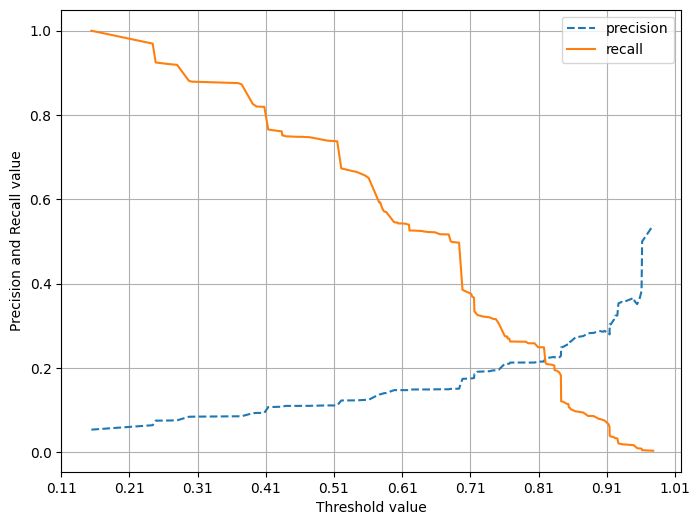

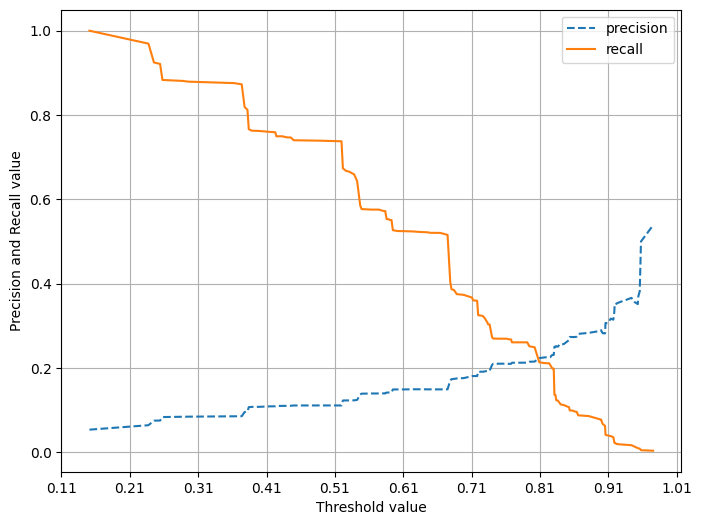

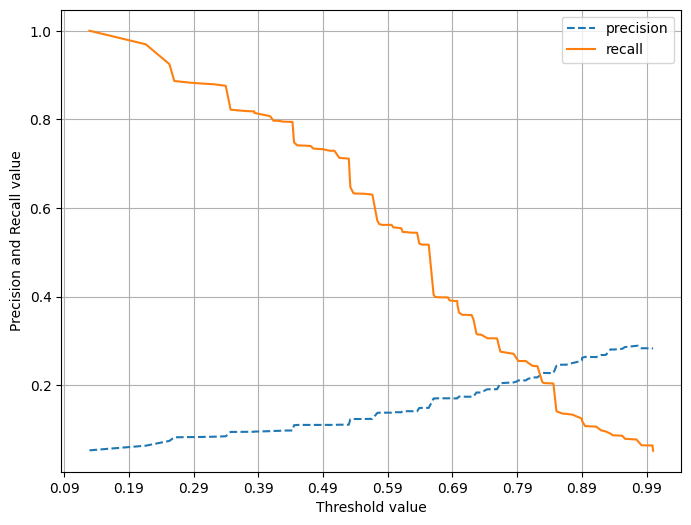

[[41678 30004]
 [  874  3174]]
[[63011  8671]
 [ 2549  1499]]


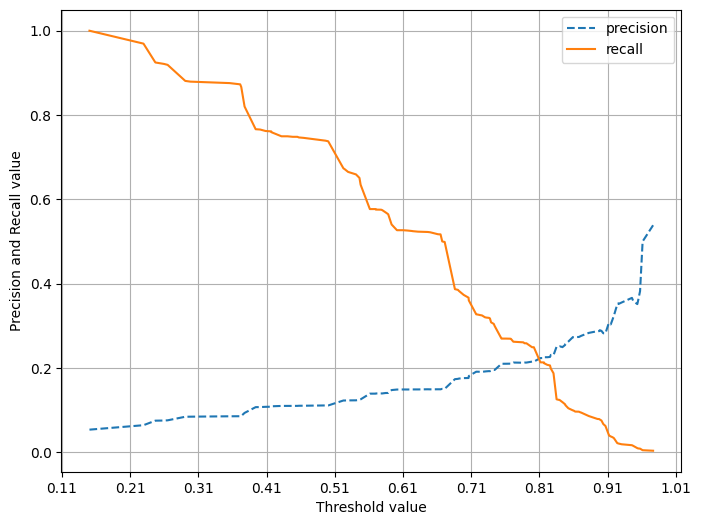

[[43374 28308]
 [ 1615  2433]]
[[16654 55028]
 [  267  3781]]
[[47782 23900]
 [ 1069  2979]]
[[44724 26958]
 [ 1139  2909]]


In [37]:
for model in model_list:
    pred = model.predict(X_test)
    try:
        pred_proba = model.predict_proba(X_test)[:,1]
        precision_recall_curve_plot(y_test, pred_proba)
    except:
        print(confusion_matrix(y_test, pred))

In [40]:
params = {
    "loss": ["squared_error", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"], 
    "penalty": ["l2", "l1", "elasticnet", None], 
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "learning_rate": ["optimal"],
    "class_weight": ["balanced", None],
}

X_train, X_test, y_train, y_test = prepare_data()
model = SGDClassifier(early_stopping=True, n_iter_no_change=5)
model_list, result = grid_search_eval(model, params)

0.0    286765
1.0    286765
Name: HEARTDISEASE, dtype: int64
Fitting 3 folds for each of 128 candidates, totalling 384 fits
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=squared_error, penalty=l2; total time=   0.7s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=squared_error, penalty=l2; total time=   0.6s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=squared_error, penalty=l2; total time=   0.6s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=squared_error, penalty=l1; total time=   1.1s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=squared_error, penalty=l1; total time=   0.7s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=squared_error, penalty=l1; total time=   1.2s
[CV] END alpha=0.0001, class_weight=balanced, learning_rate=optimal, loss=squared_error, penalty=elasticnet; total time=   0.7s
[CV] END alpha=0.0001, class

[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=huber, penalty=elasticnet; total time=   0.7s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=huber, penalty=elasticnet; total time=   0.8s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=huber, penalty=elasticnet; total time=   0.8s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=huber, penalty=None; total time=   0.8s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=huber, penalty=None; total time=   0.7s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=huber, penalty=None; total time=   0.8s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=epsilon_insensitive, penalty=l2; total time=   0.7s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=epsilon_insensitive, penalty=l2; total time=   0.8s
[CV] END alpha=0.0001, class_weight=None, learning_rate=optimal, loss=epsilon_

[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=squared_epsilon_insensitive, penalty=l2; total time=   0.6s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=squared_epsilon_insensitive, penalty=l2; total time=   0.7s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=squared_epsilon_insensitive, penalty=l1; total time=   0.7s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=squared_epsilon_insensitive, penalty=l1; total time=   0.7s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=squared_epsilon_insensitive, penalty=l1; total time=   0.9s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=squared_epsilon_insensitive, penalty=elasticnet; total time=   0.7s
[CV] END alpha=0.001, class_weight=balanced, learning_rate=optimal, loss=squared_epsilon_insensitive, penalty=elasticnet; total time=   0.7s
[CV] END alpha=0.001, class_weight=balanced, learning

[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=squared_error, penalty=elasticnet; total time=   0.8s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=squared_error, penalty=None; total time=   0.8s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=squared_error, penalty=None; total time=   0.8s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=squared_error, penalty=None; total time=   0.8s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=huber, penalty=l2; total time=   0.8s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=huber, penalty=l2; total time=   0.8s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=huber, penalty=l2; total time=   1.0s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=huber, penalty=l1; total time=   1.0s
[CV] END alpha=0.01, class_weight=balanced, learning_rate=optimal, loss=hu

[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=epsilon_insensitive, penalty=l1; total time=   0.7s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=epsilon_insensitive, penalty=elasticnet; total time=   0.7s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=epsilon_insensitive, penalty=elasticnet; total time=   0.7s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=epsilon_insensitive, penalty=elasticnet; total time=   0.8s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=epsilon_insensitive, penalty=None; total time=   0.7s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=epsilon_insensitive, penalty=None; total time=   0.7s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=epsilon_insensitive, penalty=None; total time=   0.7s
[CV] END alpha=0.01, class_weight=None, learning_rate=optimal, loss=squared_epsilon_insensitive, penalty=l2; total time=   0.7s
[C

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=huber, penalty=l1; total time=   0.8s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=huber, penalty=l1; total time=   0.8s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=huber, penalty=elasticnet; total time=   0.8s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=huber, penalty=elasticnet; total time=   0.9s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=huber, penalty=elasticnet; total time=   0.9s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=huber, penalty=None; total time=   0.7s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=huber, penalty=None; total time=   0.7s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=huber, penalty=None; total time=   0.7s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=epsilon_insensitive, penalty=l2; total time=   0.8s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=epsilon_insensitive, penalty=l2; total time=   0.7s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=epsilon_insensitive, penalty=l2; total time=   0.7s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=optimal, loss=epsilon_insensitive, penalty=l1; total time=   0.8s
[CV] END alpha=0.1, class_weight=balanced, learning_rate=o

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=huber, penalty=l1; total time=   0.8s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=huber, penalty=l1; total time=   0.7s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=huber, penalty=l1; total time=   0.8s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=huber, penalty=elasticnet; total time=   1.0s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=huber, penalty=elasticnet; total time=   0.8s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=huber, penalty=elasticnet; total time=   0.7s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=huber, penalty=None; total time=   0.7s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=huber, penalty=None; total time=   0.7s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=huber, penalty=None; total time=   0.7s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=epsilon_insensitive, penalty=l2; total time=   0.7s
[CV] END alpha=0.1, class_weight=None, learning_rate=optimal, loss=epsilon_insensitive, penalty=l2; total time=   0.

TypeError: Singleton array array(None, dtype=object) cannot be considered a valid collection.

In [ ]:
# result.fillna(0, inplace=True)
for col in result.columns:
    if col.startswith("param_"):
        print(result.groupby(col).mean()[["mean_test_precision"]])
        
for model in model_list:
    pred = model.predict(X_test)
    try:
        pred_proba = model.predict_proba(X_test)[:,1]
        precision_recall_curve_plot(y_test, pred_proba)
    except:
        print(confusion_matrix(y_test, pred))

## SVM
- 종류
    - SVC
    - LinearSVC
    - NuSVC
    - https://scikit-learn.org/stable/modules/svm.html#svm-classification
- SVC 하이퍼 파라미터
    - C: float, default=1.0
    - kernel: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
    - degree: int, default=3
    - gamma: {‘scale’, ‘auto’} or float, default=’scale’
    - coef0: float, default=0.0
    - shrinking: bool, default=True
    - probability: bool, default=False
    - tol: float, default=1e-3
    - cache_size: float, default=200
    - class_weight: dict or ‘balanced’, default=None
    - verbose: bool, default=False
    - max_iter: int, default=-1
    - decision_function_shape: {‘ovo’, ‘ovr’}, default=’ovr’
    - break_ties: bool, default=False
- NuSVC 하이퍼 파라미터
    - nu: float, default=0.5
    - kernel: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
    - degree: int, default=3
    - gamma: {‘scale’, ‘auto’} or float, default=’scale’
    - coef0: float, default=0.0
    - shrinking: bool, default=True
    - probability: bool, default=False
    - tol: float, default=1e-3
    - cache_size: float, default=200
    - class_weight: dict or ‘balanced’, default=None
    - verbose: bool, default=False
    - max_iter: int, default=-1
    - decision_function_shape: {‘ovo’, ‘ovr’}, default=’ovr’
    - break_ties: bool, default=False
- LinearSVC 하이퍼 파라미터
    - penalty: {‘l1’, ‘l2’}, default=’l2’
    - loss: {‘hinge’, ‘squared_hinge’}, default=’squared_hinge’
    - dual: bool, default=True
    - tol: float, default=1e-4
    - C: float, default=1.0
    - multi_class: {‘ovr’, ‘crammer_singer’}, default=’ovr’
    - fit_intercept: bool, default=True
    - intercept_scaling: float, default=1.0
    - class_weight: dict or ‘balanced’, default=None
    - verbose: int, default=0
    - random_state: int, RandomState instance or None, default=None
    - max_iter: int, default=1000

In [ ]:
from sklearn.svm import SVC, LinearSVC, NuSVC

model = SVC(max_iter=100, probability=True)
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

In [ ]:
model = LinearSVC(max_iter=100)
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

In [ ]:
model = NuSVC(max_iter=100, probability=True)
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

# 서대훈

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

## LightGBM 

In [ ]:
from lightgbm import LGBMClassifier

model = LGBMClassifier()
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

# 손지호

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

## XGBClassifier

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

In [26]:
import xgboost as xgb

dtrain = xgb.DMatrix(data = X_train, label = y_train)
dtest = xgb.DMatrix(data = X_test, label = y_test)

# 파라미터 설정
params = {
    'n_estimators' : [100,200,300,400,500],
    'eta' : [0.01,0.05,0.1,0,15], # learning_rate
    'max_depth' : [3,5,7,10,15],
    'gamma' : [0,1,2,3],
    'colsample_bytree' : 0.8
}

# 모델개수
num_rounds = 400

wlist = [(dtrain,'train'),(dtest,'eval') ] # eval 평가용

# 모델학습
xgb_model = xgb.train(params = params,
                      dtrain = dtrain,
                      num_boost_round = num_rounds,
#                      early_stopping_rounds = 100, 
                      evals = wlist)

XGBoostError: Invalid Parameter format for learning_rate expect float but value='[0.01, 0.05, 0.1, 0, 15]'

## KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)